### Predicting the movement of a stock with the Random Forest Classifier
In this project I try to predict the movement of a stock by training a model on different asset technical indicators to predict if the price in the future is positive or negativ.
I try to predict if the price in 5 days is up or down and then backtest my strategy if it performed well or not

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import talib as ta
import math
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
start = "2018-01-01"
end = "2020-01-01"

In [3]:
assets = ["FB", "AMZN", "AAPL", "NFLX", "GOOG"]

In [4]:
for asset in assets:
    exec("{} = web.DataReader(asset, data_source='yahoo', start = start, end = end)".format(asset))

In [5]:
asset_list = [FB, AMZN, AAPL, NFLX, GOOG]

### Calculating the technical indicators 
For the technical indicators I choosed 5 momentum indicators which are well known for certain strategies. By combining them I tried to get a good result

In [6]:
#Calculating the technical indicators with talib using the functions for momentum indicators
def indikator(asset):
    asset["RSI"] = ta.RSI(asset["Close"], timeperiod = 14)
    asset["ROC"] = ta.ROC(asset["Close"], timeperiod = 10)
    asset["%R"] = ta.WILLR(asset["High"], asset["Low"], asset["Close"], timeperiod = 14)
    asset["OBV"] = ta.OBV(asset["Close"], asset["Volume"])
    asset["MACD"], asset["MACD_SIGNAL"], asset["MACD_HIST"] = ta.MACD(asset["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    
    asset["Prediction"] = np.where(asset["Close"].shift(-5) > asset["Close"], 1, -1)

In [7]:
for asset in asset_list:
    indikator(asset)

In [8]:
df = FB.append((AMZN, AAPL, NFLX, GOOG))

In [9]:
df.dropna(inplace = True)

In [10]:
#Splitting the data into X and y variables and perform a train test split
from sklearn.model_selection import train_test_split

X = df[["RSI", "ROC", "OBV","%R", "MACD", "MACD_SIGNAL", "MACD_HIST"]]
y = df[["Prediction"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, train_size = 0.8, test_size=0.2)

In [11]:
#Creating the model with the Random Forest classifier, choosing the gini criterion 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators = 1000, oob_score = True, criterion = "gini", random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

C:\Users\Han\.conda\envs\python\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


In [12]:
print("Correct prediction in %: ", accuracy_score(y_test, y_pred, normalize= True)*100)

Correct prediction in %:  71.27659574468085


### Testing our Model on unknown data and a different time period
Since our model has a pretty good accuracy score I thought why not test it on some unknown data. 
Therefor I use a Company from the same sector as the FAANG companys and chosse a different time period to test if the model still makes good predictions.

In [13]:
#Getting the NVIDA company for the timeperiod 2020 to 2021
test_stock = web.DataReader("WMT", data_source="yahoo", start="2020-01-01", end = "2021-02-14")

#Performing the indicator function on the new data
indikator(test_stock)

#Dropping all NaN values so the model can make predictions on the new data
test_stock.dropna(inplace=True)

In [14]:
test_stock["predicted"] = model.predict(test_stock[["RSI", "ROC", "OBV","%R", "MACD", "MACD_SIGNAL", "MACD_HIST"]])

In [15]:
test_stock.head()

,High,Low,Open,Close,Volume,Adj Close,RSI,ROC,%R,OBV,MACD,MACD_SIGNAL,MACD_HIST,Prediction,predicted
Date,,,,,,,,,,,,,,,
2020-02-20,118.110001,116.860001,117.209999,117.690002,5022900.0,115.757614,52.279714,0.753364,-37.355309,11059400.0,0.350442,-0.098357,0.448799,-1,-1
2020-02-21,118.750000,117.309998,117.440002,118.580002,6242100.0,116.633011,55.742535,1.951685,-23.418726,17301500.0,0.449207,0.011156,0.438051,-1,1
2020-02-24,118.459999,115.949997,117.459999,116.320000,6616000.0,114.410110,46.512550,-0.111634,-65.880234,10685500.0,0.341184,0.077161,0.264022,-1,1
2020-02-25,117.070000,114.050003,116.349998,114.389999,7764300.0,112.511795,40.365610,-0.746204,-94.237344,2921200.0,0.098701,0.081469,0.017232,-1,-1
2020-02-26,115.169998,113.650002,114.699997,113.779999,6673300.0,111.911819,38.628014,-1.403815,-97.936550,-3752100.0,-0.141064,0.036963,-0.178027,1,-1


### Testing our Strategy 
Since our Model had predicted for each timestep in the new data, we can try to test how our strategy would have performed in that period if we stick on our model. 
I dont consider any fees for transactions or broker fees into the model. 
It only buys when there is a buy signal then holds that position for at least 5 days and then can sell it if there is a sell signal

In [16]:
def buy_sell(asset):
    BuyPrice = []
    SellPrice = []
    flag = -1
    counter = 0
    n=5
    
    for i in range(len(asset)):
        if asset["predicted"][i] == 1 and counter == 0:
            if flag != 1:
                BuyPrice.append(asset["Adj Close"][i])
                SellPrice.append(np.nan)
                flag = 1
            else:
                BuyPrice.append(np.nan)
                SellPrice.append(np.nan)
        elif asset["predicted"][i] == -1 and counter ==0:
            if flag !=0:
                BuyPrice.append(np.nan)
                SellPrice.append(asset["Adj Close"][i])
                flag = 0
            else:
                BuyPrice.append(np.nan)
                SellPrice.append(np.nan)
        else:
            BuyPrice.append(np.nan)
            SellPrice.append(np.nan)
            
        counter +=1
        if counter ==n:
            counter = 0
            
    return (BuyPrice, SellPrice)

In [17]:
buysell = buy_sell(test_stock)

In [18]:
test_stock["Buy"] = buysell[0]
test_stock["Sell"] = buysell[1]

In [19]:
test_stock

,High,Low,Open,Close,Volume,Adj Close,RSI,ROC,%R,OBV,MACD,MACD_SIGNAL,MACD_HIST,Prediction,predicted,Buy,Sell
Date,,,,,,,,,,,,,,,,,
2020-02-20,118.110001,116.860001,117.209999,117.690002,5022900.0,115.757614,52.279714,0.753364,-37.355309,11059400.0,0.350442,-0.098357,0.448799,-1,-1,NaN,115.757614
2020-02-21,118.750000,117.309998,117.440002,118.580002,6242100.0,116.633011,55.742535,1.951685,-23.418726,17301500.0,0.449207,0.011156,0.438051,-1,1,NaN,NaN
2020-02-24,118.459999,115.949997,117.459999,116.320000,6616000.0,114.410110,46.512550,-0.111634,-65.880234,10685500.0,0.341184,0.077161,0.264022,-1,1,NaN,NaN
2020-02-25,117.070000,114.050003,116.349998,114.389999,7764300.0,112.511795,40.365610,-0.746204,-94.237344,2921200.0,0.098701,0.081469,0.017232,-1,-1,NaN,NaN
2020-02-26,115.169998,113.650002,114.699997,113.779999,6673300.0,111.911819,38.628014,-1.403815,-97.936550,-3752100.0,-0.141064,0.036963,-0.178027,1,-1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,145.580002,144.460007,144.809998,145.029999,5275100.0,145.029999,51.999987,-0.800272,-32.641320,-130809300.0,-0.870416,-0.924994,0.054578,-1,1,NaN,NaN
2021-02-09,146.320007,144.580002,144.580002,145.830002,5302300.0,145.830002,54.266403,-1.138901,-23.414062,-125507000.0,-0.617390,-0.863473,0.246083,-1,1,NaN,NaN
2021-02-10,145.899994,143.539993,145.830002,144.130005,6192300.0,144.130005,48.974526,0.201619,-43.021874,-131699300.0,-0.547727,-0.800324,0.252597,-1,1,NaN,NaN


Since our first signal is a sell signal there is no point in considering it, because the first thing we want to execute is a buy order.

In [20]:
#Replacing the first Sell signal by a NaN value
test_stock["Sell"][0] = np.nan

C:\Users\Han\.conda\envs\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


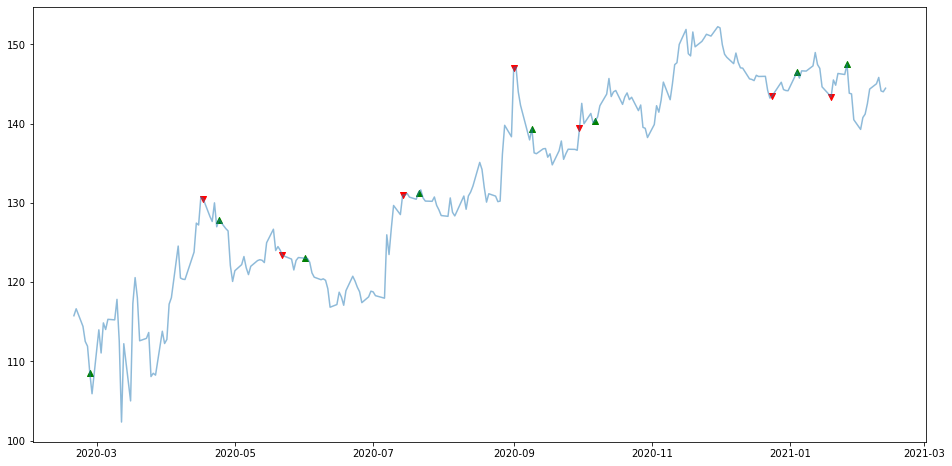

In [21]:
#Plotting our Signals on our time period
plt.figure(figsize=(16,8))
plt.scatter(test_stock.index, test_stock["Buy"], color = "green", label = "Buy", marker = "^", alpha=1)
plt.scatter(test_stock.index, test_stock["Sell"], color = "red", label = "Sell", marker = "v", alpha=1)
plt.plot(test_stock.index, test_stock["Adj Close"], alpha = 0.5)
plt.show()

### Show me the Money!
Now that we have our Buy and Sell signals we want to see how much could we have made out of our model prediction. For entertainment purposes only I thought we set a amount of 1.000.000 and buy for the full amount stocks of that company when we get a buy signal and have to hold it at least 5 days before we can sell it and see how much profit we make in our testing time period

In [22]:
def performance(data):
    performance = [1000000]
    num_stocks = 0
    for i in range(len(data)):
        if math.isnan(data["Buy"][i]) == False:
            num_stocks = performance[i]/data["Adj Close"][i]
            performance.append(num_stocks*data["Adj Close"][i])
        elif math.isnan(data["Sell"][i]) == False:
            cash = num_stocks * data["Adj Close"][i]
            performance.append(cash)
        else: 
            performance.append(performance[i])
            
    return performance

In [23]:
test_stock_performance = performance(test_stock)

In [24]:
test_stock_performance

[1000000,
 1000000,
 1000000,
 1000000,
 1000000,
 1000000,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 999999.9999999999,
 1202034.3776005153,
 1202034.3776005153,
 1202034.3776005153,
 1202034.3776005153,
 1202034.3776005153,
 1202034.3776005153,
 1202034.3776005153,
 1202034.3776005153,
 1202034.3776005153,
 1202034.3776005153,
 1202034.3776005153,
 1202034.

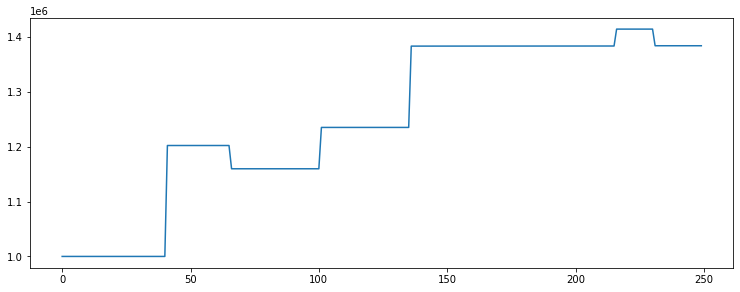

In [25]:
plt.figure(figsize= (12.6, 4.6))
plt.plot(test_stock_performance)